Load my models

In [1]:
from torchcore.util import Config
from torchcore.dnn.networks.detectors.build import build_detector
cfg = 'configs/retinanet/retinanet_resnet50_fpn_coco.py'
config = Config.fromfile(cfg)
model=build_detector(config.model)

init from pretrained model


In [2]:
from torchcore.data.datasets.build import build_dataloader
from torchcore.util.config import Config
config.dataloader_val.batch_size=1
val_dataset_loader = build_dataloader(config.dataloader_val,distributed=False)

In [3]:
json_path = os.path.expanduser('~/data/datasets/Fashionpedia/annotations/instances_attributes_val2020.json')

names = val_dataset_loader.dataset.get_coco_style_names(json_path, with_cat_id=True)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


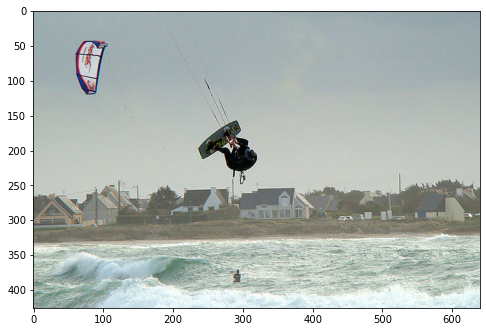

In [4]:
%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image, visulize_colored_heatmaps_with_image
from torchcore.tools.color_gen import random_colors
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO

dataset= val_dataset_loader.dataset
score_thresh = 0.6
colors = random_colors(46)
model.eval()

for i, (inputs, targets) in enumerate(val_dataset_loader):
    results = model(inputs, targets)
    input, target = dataset[i]
    im = input['data']
    boxes = results['boxes'][0].detach().numpy()
    labels= results['labels'][0].detach().numpy()-1
    scores = results['scores'][0].detach().numpy()

    keep = scores > score_thresh
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]
    draw_plain_boxes(im, boxes)
    draw_single_image(im, boxes, scores, labels, colors, class_names=names)
    #heatmap = class_hp[fpn_layer][0].detach().numpy()
    #heatmap = centerness_hp[fpn_layer][0].detach().numpy()
    #mixim=visulize_colored_heatmaps_with_image(heatmap, im)
    plt.figure(figsize=(8,8))
    plt.imshow(im)

    if i>-1:
        break

In [5]:
import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmdet import __version__
from mmdet.apis import set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import collect_env, get_root_logger

mmconfig='mmconfigs/retinanet/retinanet_r50_fpn_1x_coco.py'
mmcfg = Config.fromfile(mmconfig)
mm_model = build_detector(
        mmcfg.model,
        train_cfg=mmcfg.get('train_cfg'),
        test_cfg=mmcfg.get('test_cfg'))
mm_model.init_weights()

2022-02-04 14:36:42,655 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-02-04 14:36:42,656 - mmcv - INFO - load model from: torchvision://resnet50
2022-02-04 14:36:42,657 - mmcv - INFO - Use load_from_torchvision loader
2022-02-04 14:36:42,861 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-02-04 14:36:42,883 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-02-04 14:36:42,953 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'retina_cls', 'std': 0.01, 'bias_prob': 0.01}}
2022-02-04 14:36:43,089 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-02-04 14:36:43,090 - mmcv - INFO - 
backbone.bn1.weight - tor

In [6]:
with torch.no_grad():
    for i in range(3):
        model.neck.inner_blocks[i].weight.copy_(mm_model.neck.lateral_convs[i].conv.weight)
        model.neck.layer_blocks[i].weight.copy_(mm_model.neck.fpn_convs[i].conv.weight)
    model.neck.extra_blocks.p6.weight.copy_(mm_model.neck.fpn_convs[3].conv.weight)
    model.neck.extra_blocks.p7.weight.copy_(mm_model.neck.fpn_convs[4].conv.weight)

In [7]:
with torch.no_grad():
    for i in range(4):
        model.det_head.head.cls_head[2*i].weight.copy_(mm_model.bbox_head.cls_convs[i].conv.weight)
        model.det_head.head.bbox_head[2*i].weight.copy_(mm_model.bbox_head.reg_convs[i].conv.weight)
    
    model.det_head.head.cls_head[8].weight.copy_(mm_model.bbox_head.retina_cls.weight)
    model.det_head.head.bbox_head[8].weight.copy_(mm_model.bbox_head.retina_reg.weight)

In [8]:
model.train()
out = model.backbone(inputs['data'])
out = model.neck(out)
out = list(out.values())
out_head = model.det_head.head(out)
loss = model.det_head(inputs,out,targets)
print(loss)

{'loss_objectness': tensor(1.2173, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.7434, grad_fn=<DivBackward0>)}


In [21]:
%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image, visulize_colored_heatmaps_with_image
from torchcore.tools.color_gen import random_colors
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO

dataset= val_dataset_loader.dataset
score_thresh = 0.6
colors = random_colors(46)
model.train()
mm_model.train()

for i, (inputs, targets) in enumerate(val_dataset_loader):
    loss = model(inputs, targets)
    img_meta = [{'img_shape':imsize,'scale_factor':imscale,'flip':False} for imsize,imscale in zip(inputs['image_sizes'],inputs['image_sizes'])]
    for meta in img_meta:
        meta['pad_shape'] = (inputs['data'].shape[2],inputs['data'].shape[3],inputs['data'].shape[1])
    gt_boxes = [t['boxes'] for t in targets]
    gt_labels = [t['labels'] for t in targets]
    #the losses of five layers
    losses=mm_model(inputs['data'],img_meta,gt_bboxes=gt_boxes,gt_labels=gt_labels)
    losses_sum={}
    for k,v in losses.items():
        losses_sum[k]=sum(v)
    if loss['loss_objectness']-losses_sum['loss_cls']>1e-5:
        print(i)
        print('my cls loss',loss['loss_objectness'])
        print('mm cls loss',losses_sum['loss_cls'])
    if loss['loss_box_reg']!=losses_sum['loss_bbox']>1e-5:
        print(i)
        print('my bbox loss',loss['loss_box_reg'])
        print('mm bbox loss',losses_sum['loss_bbox'])
    if i>0:
        break

0
my cls loss tensor(1.2173, grad_fn=<DivBackward0>)
mm cls loss tensor(1.2173, grad_fn=<AddBackward0>)
1
my cls loss tensor(1.1516, grad_fn=<DivBackward0>)
mm cls loss tensor(1.1514, grad_fn=<AddBackward0>)
1
my bbox loss tensor(0.6852, grad_fn=<DivBackward0>)
mm bbox loss tensor(0.6852, grad_fn=<AddBackward0>)


In [22]:
loss['loss_box_reg']-losses_sum['loss_bbox']

tensor(5.9605e-08, grad_fn=<SubBackward0>)

In [18]:
loss['loss_objectness']-losses_sum['loss_cls']

tensor(0.0002, grad_fn=<SubBackward0>)

In [9]:
mm_model.train()
mm_out=mm_model.backbone(inputs['data'])
mm_out=mm_model.neck(mm_out)

In [10]:
#mm_head_out=mm_model.bbox_head(mm_out)
from mmdet.core import (anchor_inside_flags, build_assigner, build_bbox_coder,
                        build_prior_generator, build_sampler, images_to_levels,
                        multi_apply, unmap)
mm_head_out = multi_apply(mm_model.bbox_head.forward_single, mm_out)

In [11]:
img_meta = [{'img_shape':imsize,'scale_factor':imscale,'flip':False} for imsize,imscale in zip(inputs['image_sizes'],inputs['image_sizes'])]
for meta in img_meta:
    meta['pad_shape'] = (inputs['data'].shape[2],inputs['data'].shape[3],inputs['data'].shape[1])
gt_boxes = [t['boxes'] for t in targets]
gt_labels = [t['labels'] for t in targets]
#the losses of five layers
losses=mm_model(inputs['data'],img_meta,gt_bboxes=gt_boxes,gt_labels=gt_labels)
losses_sum={}
for k,v in losses.items():
    losses_sum[k]=sum(v)
print(losses_sum)

{'loss_cls': tensor(1.2173, grad_fn=<AddBackward0>), 'loss_bbox': tensor(0.7434, grad_fn=<AddBackward0>)}


In [45]:
featmap_sizes = [featmap.size()[-2:] for featmap in out]
device = out[0].device

mm_anchor,mm_valid = mm_model.bbox_head.get_anchors(featmap_sizes,img_meta,device=device)
label_channels = mm_model.bbox_head.cls_out_channels if mm_model.bbox_head.use_sigmoid_cls else 1
cls_reg_targets = mm_model.bbox_head.get_targets(
    mm_anchor,
    mm_valid,
    gt_boxes,
    img_meta,
    gt_bboxes_ignore_list=None,
    gt_labels_list=gt_labels,
    label_channels=label_channels)
(labels_list, label_weights_list, bbox_targets_list, bbox_weights_list,
         num_total_pos, num_total_neg) = cls_reg_targets

In [50]:
labels_list

5

In [48]:
(label_weights_list[0]==1).sum()

tensor(136478)

In [24]:
img_meta

[{'img_shape': torch.Size([800, 1201]),
  'scale_factor': torch.Size([800, 1201]),
  'flip': False,
  'pad_shape': (800, 1216, 3),
  'batch_input_shape': (800, 1216)}]

In [22]:
featmap_sizes

[torch.Size([100, 152]),
 torch.Size([50, 76]),
 torch.Size([25, 38]),
 torch.Size([13, 19]),
 torch.Size([7, 10])]

In [28]:
#out_head_v=list(out_head.values())
anchors = model.det_head.anchor_generater(inputs, out)

In [21]:
model.det_head.anchor_generater.cell_anchors[0]

tensor([[-22.6274, -11.3137,  22.6274,  11.3137],
        [-28.5088, -14.2544,  28.5088,  14.2544],
        [-35.9188, -17.9594,  35.9188,  17.9594],
        [-16.0000, -16.0000,  16.0000,  16.0000],
        [-20.1587, -20.1587,  20.1587,  20.1587],
        [-25.3984, -25.3984,  25.3984,  25.3984],
        [-11.3137, -22.6274,  11.3137,  22.6274],
        [-14.2544, -28.5088,  14.2544,  28.5088],
        [-17.9594, -35.9188,  17.9594,  35.9188]])

In [13]:
mm_model.bbox_head.prior_generator.base_anchors[0]

tensor([[-22.6274, -11.3137,  22.6274,  11.3137],
        [-28.5088, -14.2544,  28.5088,  14.2544],
        [-35.9188, -17.9594,  35.9188,  17.9594],
        [-16.0000, -16.0000,  16.0000,  16.0000],
        [-20.1587, -20.1587,  20.1587,  20.1587],
        [-25.3984, -25.3984,  25.3984,  25.3984],
        [-11.3137, -22.6274,  11.3137,  22.6274],
        [-14.2544, -28.5088,  14.2544,  28.5088],
        [-17.9594, -35.9188,  17.9594,  35.9188]])

In [25]:
mm_anchor_all = [torch.cat(a) for a in mm_anchor]

In [32]:
(anchors[0]-mm_anchor_all[0]==0).all()

tensor(True)

In [30]:
mm_anchor_all[0]

tensor([[ -22.6274,  -11.3137,   22.6274,   11.3137],
        [ -28.5088,  -14.2544,   28.5088,   14.2544],
        [ -35.9188,  -17.9594,   35.9188,   17.9594],
        ...,
        [ 970.9807,  405.9613, 1333.0193, 1130.0387],
        [ 923.9299,  311.8599, 1380.0701, 1224.1401],
        [ 864.6497,  193.2994, 1439.3503, 1342.7006]])

In [72]:
for i in range(5):
    print(mm_anchor[0][i].shape)

torch.Size([136800, 4])
torch.Size([34200, 4])
torch.Size([8550, 4])
torch.Size([2223, 4])
torch.Size([630, 4])


In [62]:
mm_anchor_all[0].shape

torch.Size([182403, 4])

In [17]:
print(inputs['data'].shape)
for k,v in out.items():
    print(k,v.shape)

torch.Size([1, 3, 800, 1216])
2 torch.Size([1, 256, 100, 152])
3 torch.Size([1, 256, 50, 76])
p5 torch.Size([1, 256, 25, 38])
p6 torch.Size([1, 256, 13, 19])
p7 torch.Size([1, 256, 7, 10])


In [57]:
for k,v in out_head.items():
    print(k,out_head[k][0].shape)
out_head['2'][0].shape

2 torch.Size([1, 720, 100, 152])
3 torch.Size([1, 720, 50, 76])
c5 torch.Size([1, 720, 25, 38])
p6 torch.Size([1, 720, 13, 19])
p7 torch.Size([1, 720, 7, 10])


torch.Size([1, 720, 100, 152])

In [16]:
loss

{'loss_objectness': tensor(1.2131, grad_fn=<DivBackward0>),
 'loss_box_reg': tensor(0.7660, grad_fn=<DivBackward0>)}

In [63]:
len(mm_head_out[0])

5

In [11]:
for i,k in enumerate(['2','3','c5','p6','p7']):
    for j in range(2):
        if not (out_head[i][j]==mm_head_out[j][i]).all():
            print(k,i)

In [59]:
o[1].shape

torch.Size([1, 36, 50, 76])

In [50]:
len(mm_head_out)
for o in mm_head_out:
#    print(o[0].shape)

2

In [96]:
(out['p7']-mm_out[4]==0).all()

tensor(True)

In [15]:
mm_model.neck

FPN(
  (lateral_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvModule(
      (conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ConvModule(
      (conv): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (fpn_convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvModule(
      (conv): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (4): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
)
init_cfg={'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}

In [46]:
mm_model.neck.lateral_convs[0].conv.weight

Parameter containing:
tensor([[[[ 0.0089]],

         [[-0.0146]],

         [[ 0.0061]],

         ...,

         [[-0.0321]],

         [[ 0.0815]],

         [[ 0.0473]]],


        [[[ 0.0414]],

         [[ 0.0649]],

         [[ 0.0858]],

         ...,

         [[-0.0172]],

         [[-0.0727]],

         [[ 0.0785]]],


        [[[ 0.0290]],

         [[ 0.0455]],

         [[-0.0305]],

         ...,

         [[-0.0734]],

         [[ 0.0244]],

         [[-0.0645]]],


        ...,


        [[[-0.0556]],

         [[ 0.0828]],

         [[ 0.0670]],

         ...,

         [[ 0.0353]],

         [[ 0.0197]],

         [[ 0.0801]]],


        [[[-0.0222]],

         [[-0.0245]],

         [[ 0.0428]],

         ...,

         [[-0.0134]],

         [[-0.0622]],

         [[-0.0555]]],


        [[[ 0.0759]],

         [[-0.0230]],

         [[-0.0825]],

         ...,

         [[ 0.0664]],

         [[ 0.0710]],

         [[-0.0366]]]], requires_grad=True)

In [32]:
mm_out[1].shape

torch.Size([1, 512, 100, 152])

In [93]:
out['2']-mm_out[0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [8]:
x=model.backbone.conv1(inputs['data'])
x = model.backbone.bn1(x)
x = model.backbone.relu(x)
x = model.backbone.maxpool(x)
x = model.backbone.layer1(x)
x = model.backbone.layer2[0].conv1(x)
x = model.backbone.layer2[0].bn1(x)

mm_model.train()
mx=mm_model.backbone.conv1(inputs['data'])
mx = mm_model.backbone.norm1(mx)
mx = mm_model.backbone.relu(mx)
mx = mm_model.backbone.maxpool(mx)
mx = mm_model.backbone.layer1(mx)
mx = mm_model.backbone.layer2[0].conv1(mx)
mx = mm_model.backbone.layer2[0].norm1(mx)


In [9]:
(mx==x).all()

tensor(True)

In [10]:
model.backbone.layer2[0].bn1.training
#model.backbone.bn1.training

False

In [11]:
mm_model.backbone.layer2[0].norm1.training
#mm_model.backbone.norm1.training

False

In [12]:
mm_model.backbone.norm_eval

True